In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /data/reddylab/Kuei 
WORK DIRECTORY:     /data/reddylab/Kuei/out 
CODE DIRECTORY:     /data/reddylab/Kuei/code 
PATH OF SOURCE:     /data/reddylab/Kuei/source 
PATH OF EXECUTABLE: /data/reddylab/Kuei/bin 
PATH OF ANNOTATION: /data/reddylab/Kuei/annotation 
PATH OF PROJECT:    /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS:    /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 


In [6]:
ASSAYS  = c("KS91_K562_ASTARRseq", "A001_K562_WSTARRseq", "Tewhey_K562_TileMPRA")
FOLDER  = "coverage_astarrseq_peak_macs_input"
REGIONS = c("GATA1", "MYC", "FADS")
PROCESS = c("raw", "norm", "deseq")

In [10]:
get_region = function(assay){ifelse(assay=="Tewhey_K562_TileMPRA", "GATA1", "WGS")}

In [45]:
lst_dat_ori = lapply(ASSAYS, function(assay){
    region = get_region(assay)
    print(region)
    fdiry   = file.path(FD_RES, "results", assay, FOLDER, "summary")
    fname = paste("result", "Log2FC", "raw", region, "tsv", sep=".")
    fpath = file.path(fdiry, fname)
    print(fpath)
    dat_log2fc_raw = read_tsv(fpath, show_col_types = FALSE)
    
    fname = paste("result", "Log2FC", "deseq", region, "tsv", sep=".")
    fpath = file.path(fdiry, fname)
    print(fpath)
    dat_log2fc_deseq = read_tsv(fpath, show_col_types = FALSE)
    
    dat1 = dat_log2fc_raw %>%
        dplyr::rename(Log2FC_raw = log2FoldChange)
    
    dat2 = dat_log2fc_deseq %>%
        dplyr::select(Peak, log2FoldChange) %>%
        dplyr::rename(Log2FC_deseq = log2FoldChange)
    
    dat = dat1 %>% left_join(dat2, by="Peak")
    return(dat)
})

[1] "WGS"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.raw.WGS.tsv"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.deseq.WGS.tsv"
[1] "WGS"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.raw.WGS.tsv"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.deseq.WGS.tsv"
[1] "GATA1"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/Tewhey_K562_TileMPRA/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.raw.GATA1.tsv"
[1] "/data/reddylab/Kuei/out/proj_combeffect_encode_fcc/results/Tewhey_K562_TileMPRA/coverage_astarrseq_peak_macs_input/summary/result.Log2FC.deseq.GATA1.tsv"


In [47]:
lst   = lst_dat_ori
print(lapply(lst, dim))
cat("+++++++++++++++++++++\n")
lst   = lapply(lst, function(dat){dat$Peak})
peaks = unique(Reduce(intersect, lst))

lst   = lst_dat_ori
lst   = lapply(lst, function(dat){
    dat = dat %>% dplyr::filter(Peak %in% peaks)
})
print(lapply(lst, dim))

lst_dat = lst

[[1]]
[1] 246852      8

[[2]]
[1] 246832      8

[[3]]
[1] 206   8

+++++++++++++++++++++
[[1]]
[1] 206   8

[[2]]
[1] 206   8

[[3]]
[1] 206   8



In [48]:
dat = lst_dat[[1]]
dat = dat %>% arrange(-Input)
peaks = dat$Peak

In [49]:
head(dat)

Chrom,Start,End,Peak,Input,Output,Log2FC_raw,Log2FC_deseq
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chrX,48800352,48802804,chrX_48800352_48802804,15512.833,4716.75,-1.717597,0.6907942
chrX,48896952,48898644,chrX_48896952_48898644,8580.000,2213.50,-1.954648,0.4399227
chrX,48957155,48958880,chrX_48957155_48958880,8393.833,1762.00,-2.252116,0.1739485
chrX,49043005,49044135,chrX_49043005_49044135,7349.333,1950.25,-1.913954,0.5060386
chrX,49100046,49101908,chrX_49100046_49101908,6487.167,847.25,-2.936729,-0.5149468
chrX,49155029,49156747,chrX_49155029_49156747,6390.500,1115.50,-2.518238,-0.1436541


Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


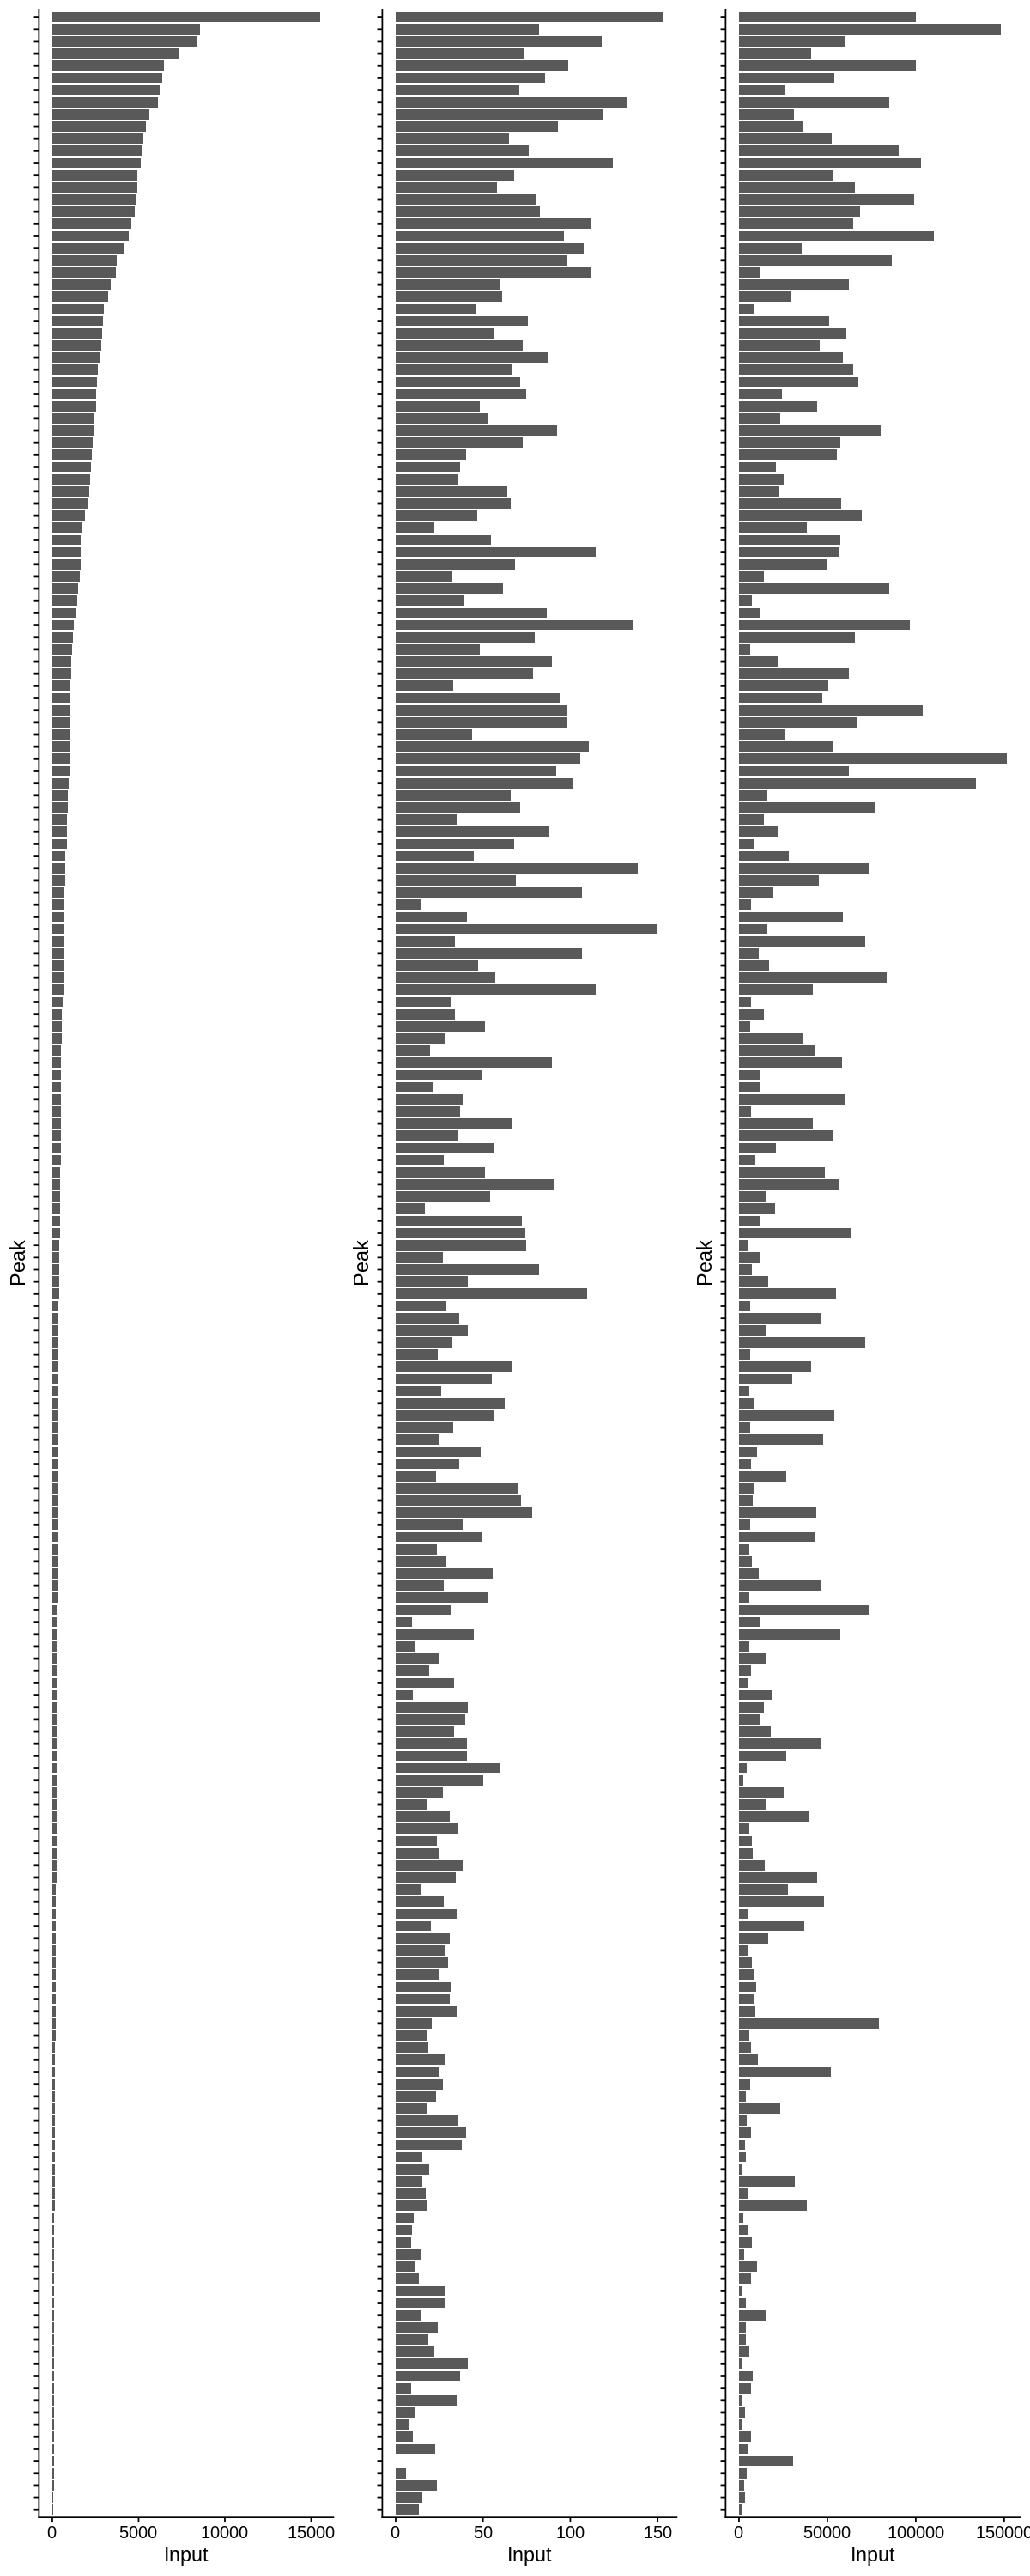

In [50]:
lst_gpt = lapply(seq_along(lst_dat), function(idx){
    dat = lst_dat[[idx]]
    dat$Peak = factor(dat$Peak, levels=rev(peaks))

    gpt = ggplot(dat, aes(x=Input, y=Peak)) + 
        geom_histogram(stat="identity") + 
        theme_cowplot() + 
        theme(axis.text.y = element_blank())#element_text(vjust=0.5, angle=270))
    return(gpt)
})

options(repr.plot.height=25, repr.plot.width=10)
plot_grid(
    lst_gpt[[1]], 
    lst_gpt[[2]], 
    lst_gpt[[3]], 
    nrow = 1, align = "h")

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


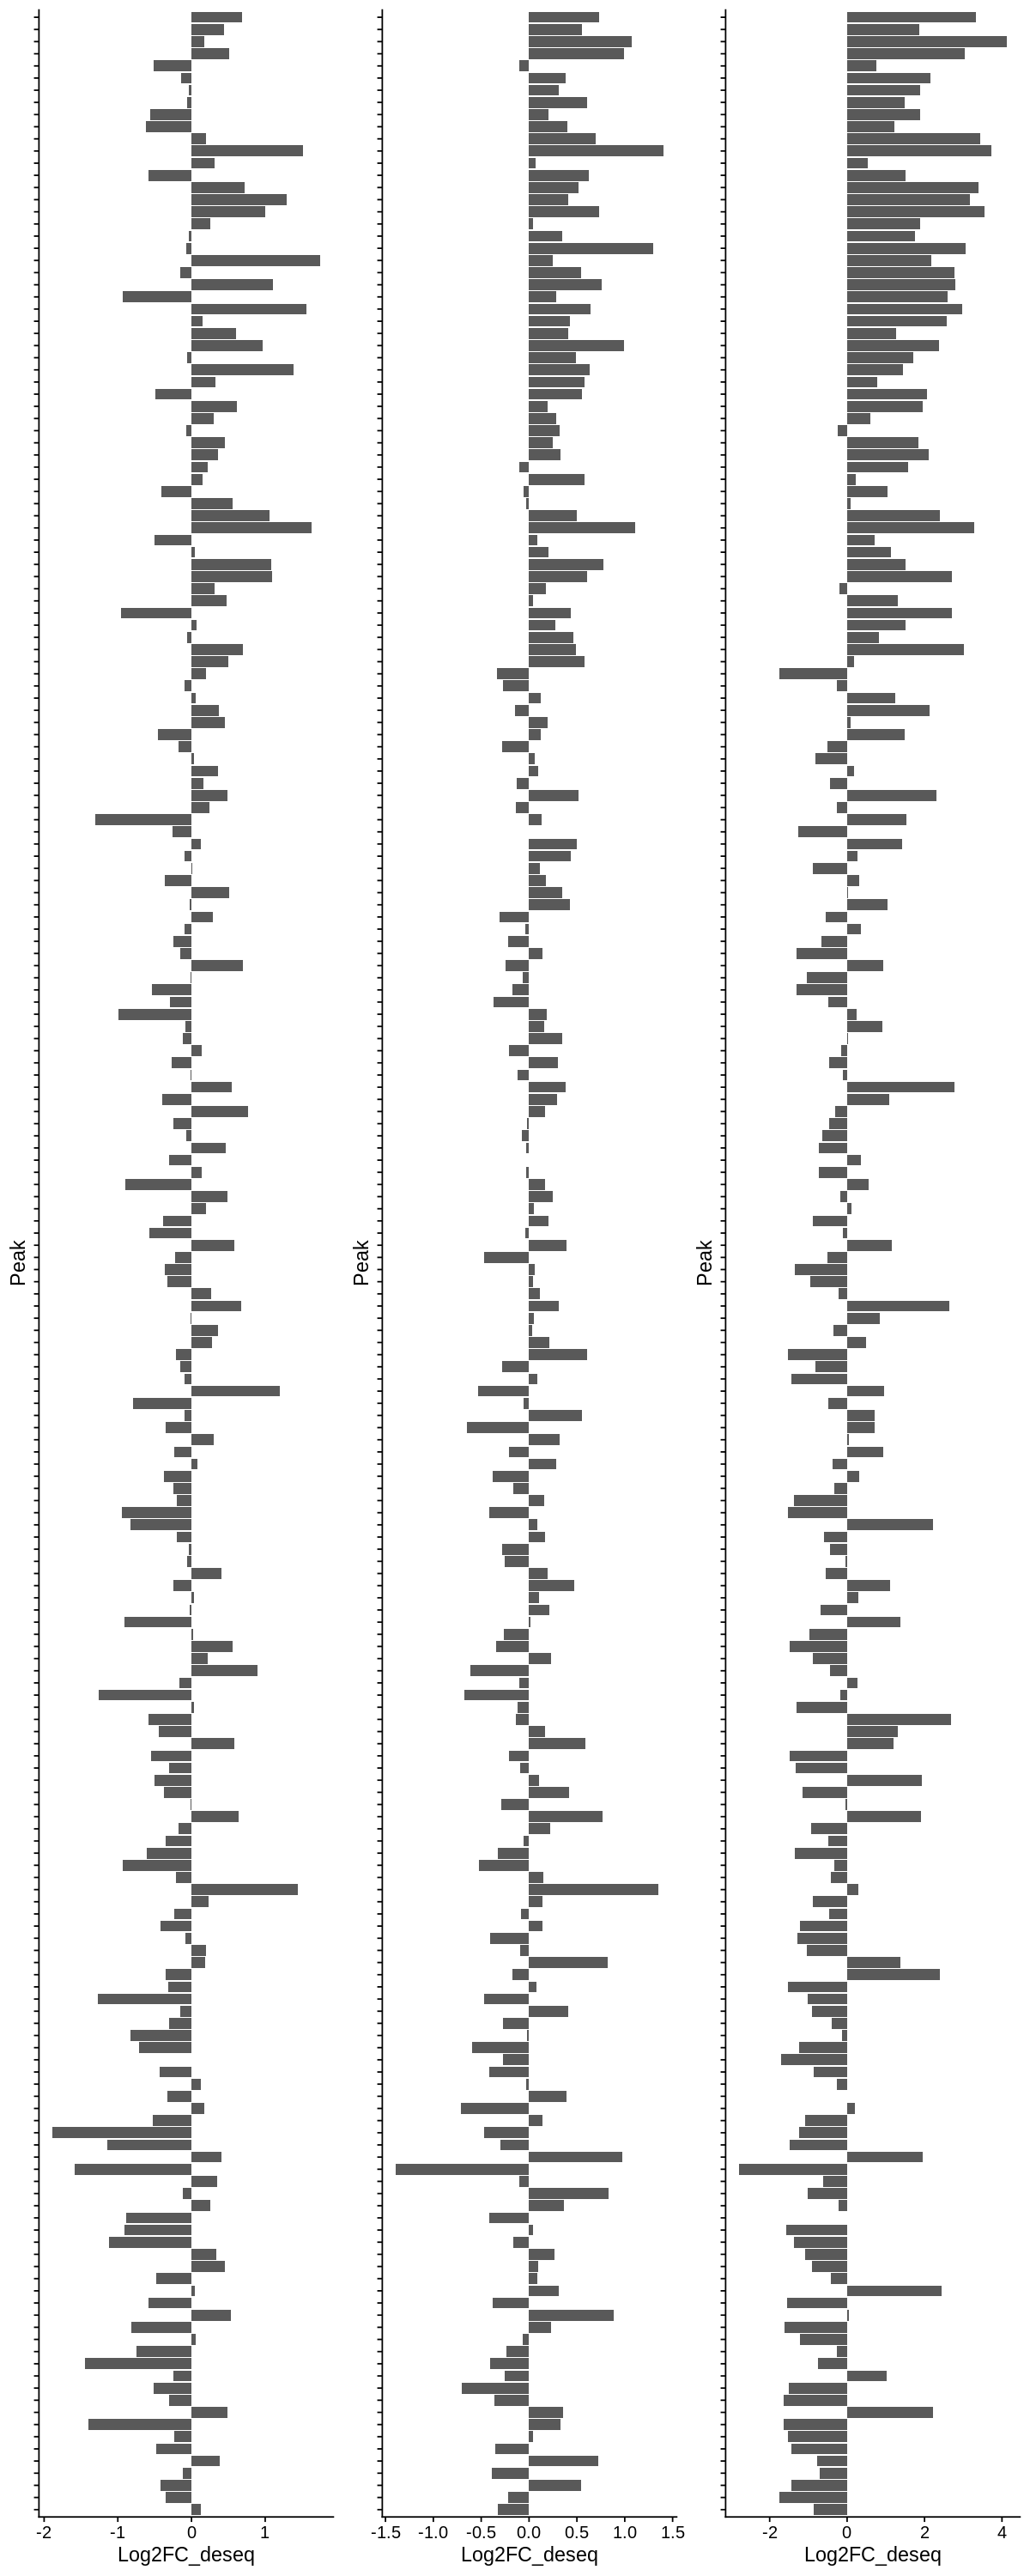

In [51]:
lst_gpt = lapply(seq_along(lst_dat), function(idx){
    dat = lst_dat[[idx]]
    dat$Peak = factor(dat$Peak, levels=rev(peaks))

    gpt = ggplot(dat, aes(x=Log2FC_deseq, y=Peak)) + 
        geom_histogram(stat="identity") + 
        theme_cowplot() + 
        theme(axis.text.y = element_blank())#element_text(vjust=0.5, angle=270))
    return(gpt)
})

options(repr.plot.height=25, repr.plot.width=10)
plot_grid(
    lst_gpt[[1]], 
    lst_gpt[[2]], 
    lst_gpt[[3]], 
    nrow = 1, align = "h")